In [2]:
import boto3
from pyathena import connect
import csv

import pandas as pd
import io

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
s3 = boto3.client('s3')

In [4]:
bucket_name = 'aai-540-final-data'

In [6]:
pre_processed_data_path = 'data/pre_processed_data.tsv'

data_obj = s3.get_object(Bucket=bucket_name, Key=pre_processed_data_path)

final_df = pd.read_csv(io.BytesIO(data_obj['Body'].read()), delimiter='\t')

In [9]:
final_df.head()

,text,emotions,id
0,"He isn't as big, but he's still quite popular....",0,eczuekb
1,that's adorable asf,0,ef961hv
2,"I have, and now that you mention it, I think t...",27,ed9w1hm
3,"I wanted to downvote this, but it's not your f...",27,ee52cjs
4,Build a wall? /jk,27,edsqvyx


In [12]:
len(final_df)

54263

In [14]:
# split into train, text, val
X = final_df.drop('emotions', axis=1)
y = final_df['emotions']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [16]:
print(f'Train length: {len(X_train)}, test length: {len(X_test)}, val length: {len(X_val)}')

Train length: 42731, test length: 5427, val length: 6105


In [17]:
# initial data exploration

# Calculating text length in terms of words and characters
word_count = X_train['text'].apply(lambda x: len(str(x).split()))
char_count = X_train['text'].apply(lambda x: len(str(x)))

# Calculating the average word length
def avg_word(sentence):
    words = sentence.split()
    return sum(len(word) for word in words)/len(words)

avg_word_len = X_train['text'].apply(lambda x: avg_word(x))

# Word frequency
freq = pd.Series(' '.join(X_train['text']).split()).value_counts()[:20]

# Display basic statistics and the most frequent words
print('Word Count: ', word_count.describe())
print('Character Count: ', char_count.describe())
print('Average Word Length: ', avg_word_len.describe())
print('Most Frequent Words: ', freq)

Word Count:  count    42731.000000
mean        12.791229
std          6.709729
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         33.000000
Name: text, dtype: float64
Character Count:  count    42731.000000
mean        68.148230
std         36.739159
min          2.000000
25%         38.000000
50%         65.000000
75%         95.000000
max        703.000000
Name: text, dtype: float64
Average Word Length:  count    42731.000000
mean         4.475041
std          0.946166
min          1.000000
25%          3.950000
50%          4.360000
75%          4.850000
max         49.285714
Name: text, dtype: float64
Most Frequent Words:  the       15869
I         14642
to        12043
a         11808
and        8056
is         7580
you        6984
of         6821
that       6108
[NAME]     5585
for        5422
in         5324
it         5097
this       4248
was        3671
be         3298
on         3169
my         3096
have       3045
with       3

In [18]:
y_train.value_counts()

emotions
27    12533
0      4079
4      2551
1      2241
3      2139
15     2125
7      1742
10     1655
18     1504
2      1497
6      1225
9      1008
17      994
20      964
5       953
25      835
26      758
13      685
22      678
11      572
8       543
14      513
24      390
12      237
19      104
23       83
16       68
21       55
Name: count, dtype: int64

In [19]:
# Loading the file with emotion label names
emotion_labels_obj = s3.get_object(Bucket=bucket_name, Key='data/emotions.txt')
emotion_labels_data = emotion_labels_obj['Body'].read()

# Converting the data from bytes to string and splitting by lines
emotion_labels = emotion_labels_data.decode('utf-8').splitlines()

In [22]:
# Split emotions column to get count of each emotion individually
split_emotions = y_train.astype(str).str.split(',')
all_emotions = split_emotions.explode().astype(int)
# Creating a mapping of indices to emotion labels
emotion_index_to_label = {index: label for index, label in enumerate(emotion_labels)}

# Applying the mapping to the emotions dataset
labeled_emotions = all_emotions.map(emotion_index_to_label)

# Counting occurrences of each emotion label
labeled_emotion_counts = labeled_emotions.value_counts()

In [23]:
labeled_emotion_counts

emotions
neutral           12533
admiration         4079
approval           2551
amusement          2241
annoyance          2139
gratitude          2125
curiosity          1742
disapproval        1655
love               1504
anger              1497
confusion          1225
disappointment     1008
joy                 994
optimism            964
caring              953
sadness             835
surprise            758
excitement          685
realization         678
disgust             572
desire              543
fear                513
remorse             390
embarrassment       237
nervousness         104
relief               83
grief                68
pride                55
Name: count, dtype: int64

In [24]:
all_emotions = split_emotions.explode().astype(int)

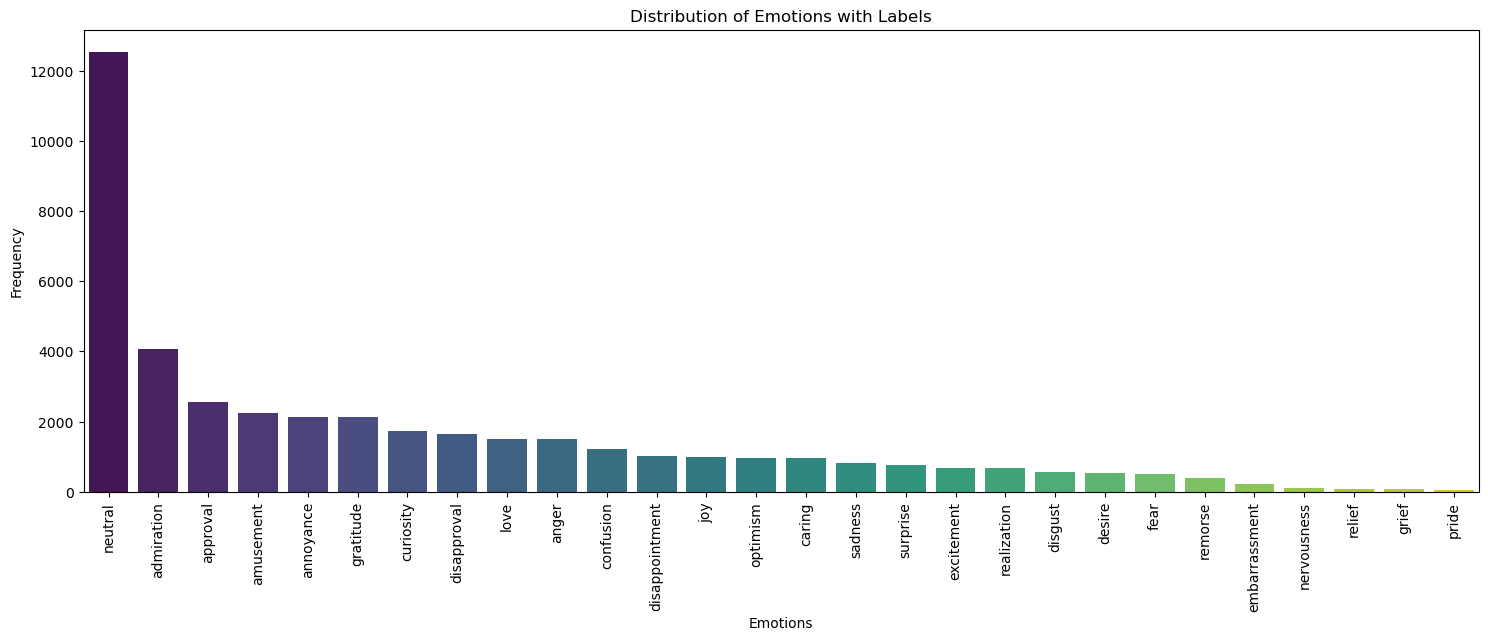

In [25]:
# Creating a mapping of indices to emotion labels
emotion_index_to_label = {index: label for index, label in enumerate(emotion_labels)}

# Applying the mapping to the emotions dataset
labeled_emotions = all_emotions.map(emotion_index_to_label)

# Counting occurrences of each emotion label
labeled_emotion_counts = labeled_emotions.value_counts()

# Plotting the distribution of emotions with correct labels and data
plt.figure(figsize=(18, 6))
sns.barplot(x=labeled_emotion_counts.index, y=labeled_emotion_counts.values, hue=labeled_emotion_counts.index, palette="viridis", legend=False)
plt.title('Distribution of Emotions with Labels')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [26]:
emotion_categories = {
	"anger": ["anger", "annoyance", "disapproval"],
	"disgust": ["disgust"],
	"fear": ["fear", "nervousness"],
	"happy": ["joy", "amusement", "approval", "gratitude"],
	"optimistic": ["optimism", "relief", "pride", "excitement"],
	"affectionate": [ "love", "caring", "admiration",  "desire"],
	"sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
	"surprise": ["surprise", "realization", "confusion", "curiosity"],
	"neutral": ["neutral"]
} 


emotion_to_category = {}
for category, emotions in emotion_categories.items():
	for emotion in emotions:
		emotion_to_category[emotion] = category

category_counts = pd.Series(dtype=int).reindex(emotion_categories.keys(), fill_value=0)

for emotion, count in labeled_emotion_counts.items():
	category = emotion_to_category[emotion]
	if category:
		category_counts[category] += count

category_counts

anger            5291
disgust           572
fear              617
happy            7911
optimistic       1787
affectionate     7079
sadness          2538
surprise         4403
neutral         12533
dtype: int64